In [29]:
%cd /scratch/mt/ashapiro/Hate_Speech/
from contrastive_utils import *
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline
import pandas as pd
from tqdm.autonotebook import tqdm
from sklearn.linear_model import LogisticRegression

/scratch/mt/ashapiro/Hate_Speech


In [2]:
def plot_cf(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [56]:
def _proccess_one(preds):
    temp_data = {'score_0':[], 'score_1':[]}
    for pred in preds:
        label = int(pred['label'].split('_')[-1])
        
        if label == 0 :
            score_0 = pred['score']
            score_1 = 1 - score_0
        else:
            score_1 = pred['score']
            score_0 = 1 - score_1

        temp_data['score_0'].append(score_0)
        temp_data['score_1'].append(score_1)
    temp = pd.DataFrame.from_dict(temp_data)
    temp['pred'] = temp.apply(lambda row: 1 if row.score_0 < row.score_1 else 0, axis=1)
    return temp

def get_weighted_ensemble_data(model_lists, test_df, classifier):
    df = pd.DataFrame()
    for model in tqdm(model_lists):
        if model == marbert_classification_only_checkpoint :
            _model = bebo.from_pretrained(model)
        else:
            _model = BertForSequenceClassification.from_pretrained(model)
        _pipeline = pipeline(task="text-classification", model=_model, tokenizer=model, batch_size = 64, device=0)
        model_name = model.split('/')[-3]
        ops = _proccess_one(_pipeline(list(test_df.text.values)))
        df[f'{model_name}_z']= ops['score_0']
        df[f'{model_name}_1']= ops['score_1']
    df['label'] = test_df.labels.values
    X, y= df.drop(columns='label').values, df.label.values
    classifier.fit(X,y)
    y_pred = classifier.predict(X)
    print(classification_report(y_true=y, y_pred=y_pred))
    plot_cf(confusion_matrix(y, y_pred))    
    
    return df, classifier     
        
        
        
def ensemble(model_lists, test_df, pred):
    df = pd.DataFrame.from_dict({'score_0':[0]*len(test_df), 'score_1':[0]*len(test_df)})
    models_outputs = {}
    for model in tqdm(model_lists):
        if model == marbert_classification_only_checkpoint :
            _model = bebo.from_pretrained(model)
        else:
            _model = BertForSequenceClassification.from_pretrained(model)
        _pipeline = pipeline(task="text-classification", model=_model, tokenizer=model, batch_size = 64, device=0)
        model_name = model.split('/')[-3]
        models_outputs[model_name]= _proccess_one(_pipeline(list(test_df.text.values)))
        df = df.add(models_outputs[model_name][['score_0','score_1']])
    df = df/len(model_lists)
    df['tweet'] = test_df.text.values
    df['pred'] = df.apply(lambda row: 1 if row.score_0 < row.score_1 else 0, axis=1)
    if not pred 
        #df['true'] = test_df.labels.values
    return df, models_outputs

def stat_each(models_output):
    for model_name, df in models_output.items():
        print(model_name)
        print(classification_report(y_true=test.labels.values, y_pred=df.pred.values))
        plot_cf(confusion_matrix(test.labels.values, df.pred.values))
        print("=====================================================================")

In [26]:
train, test = getData(sub_task="A", pre_proccessed=True, return_type="pandas")

# 

In [4]:
marbert_classification_only_checkpoint = "/scratch/mt/ashapiro/Hate_Speech/Checkpoints/SentenceBert/Classifiers/Marbertv2_best/checkpoint-278/" #0.8505582936759521
online_contrastive_50k = "/scratch/mt/ashapiro/Hate_Speech/Checkpoints/SentenceBert/Classifiers/MarbertV2_OnlineContrastive_50K/checkpoint-1807/" #0.850946919178447
contrastive_50k = "/scratch/mt/ashapiro/Hate_Speech/Checkpoints/SentenceBert/Classifiers/MarbertV2_Contrastive_50K/checkpoint-1251/" #0.849672373705347
batch_all_triplet = "/scratch/mt/ashapiro/Hate_Speech/Checkpoints/SentenceBert/Classifiers/BatchAllTripletLoss/checkpoint-1946/" #0.847643942694422
online_contrastive_1m = "/scratch/mt/ashapiro/Hate_Speech/Checkpoints/SentenceBert/Classifiers/MarbertV2_OnlineContrastive_1M/checkpoint-1946/" #0.847271070115216
models_list = [marbert_classification_only_checkpoint, 
               online_contrastive_50k, 
               contrastive_50k,
               batch_all_triplet,
               online_contrastive_1m
              ]
reproduce = [marbert_classification_only_checkpoint, contrastive_50k, batch_all_triplet]

## Top 2

100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


              precision    recall  f1-score   support

           0       0.91      0.90      0.90       866
           1       0.79      0.81      0.80       404

    accuracy                           0.87      1270
   macro avg       0.85      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



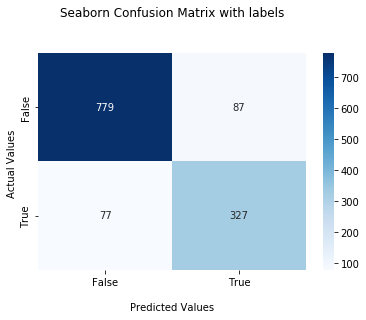

In [12]:
df, models_output = ensemble(model_lists=models_list[:2] ,test_df=test)
print(classification_report(y_true=df.true.values, y_pred=df.pred.values))
plot_cf(confusion_matrix(test.labels.values, df.pred.values))

Marbertv2_best
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       866
           1       0.79      0.80      0.80       404

    accuracy                           0.87      1270
   macro avg       0.85      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



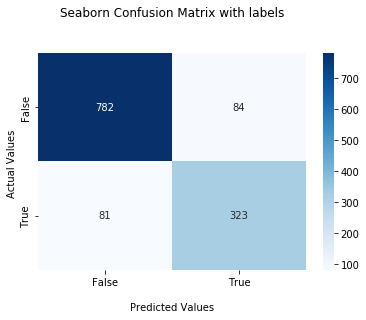

MarbertV2_OnlineContrastive_50K
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       866
           1       0.79      0.80      0.80       404

    accuracy                           0.87      1270
   macro avg       0.85      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



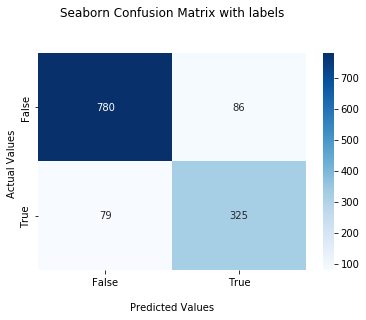

In [9]:
stat_each(models_output)

### Weighted 

100%|██████████| 2/2 [00:06<00:00,  3.24s/it]

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       866
           1       0.82      0.78      0.80       404

    accuracy                           0.88      1270
   macro avg       0.86      0.85      0.86      1270
weighted avg       0.88      0.88      0.88      1270



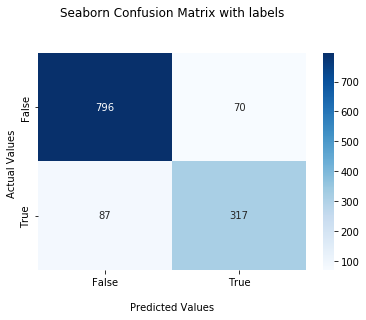

In [37]:
classifier = LogisticRegression()
df, classifier = get_weighted_ensemble_data(model_lists=models_list[:2] ,test_df=test, classifier=classifier)

## Top 3

100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       866
           1       0.80      0.81      0.80       404

    accuracy                           0.87      1270
   macro avg       0.85      0.86      0.85      1270
weighted avg       0.87      0.87      0.87      1270



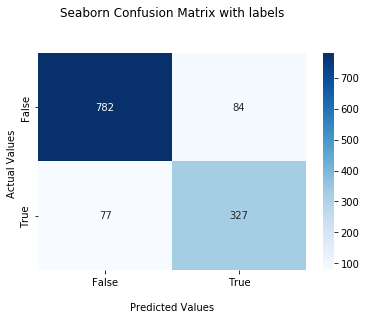

In [13]:
df, models_output = ensemble(model_lists=models_list[:3] ,test_df=test)
print(classification_report(y_true=df.true.values, y_pred=df.pred.values))
plot_cf(confusion_matrix(test.labels.values, df.pred.values))

100%|██████████| 3/3 [00:09<00:00,  3.17s/it]

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       866
           1       0.82      0.78      0.80       404

    accuracy                           0.87      1270
   macro avg       0.86      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



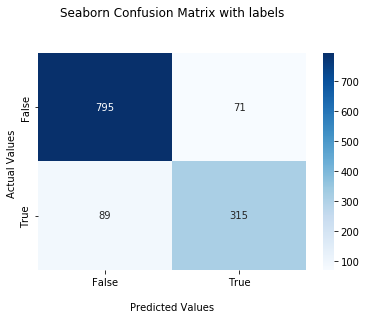

In [38]:
classifier = LogisticRegression()
df, classifier = get_weighted_ensemble_data(model_lists=models_list[:3] ,test_df=test, classifier=classifier)

## Top 4

In [39]:
df, models_output = ensemble(model_lists=models_list[:4] ,test_df=test)
print(classification_report(y_true=df.true.values, y_pred=df.pred.values))

100%|██████████| 4/4 [00:13<00:00,  3.50s/it]

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       866
           1       0.79      0.81      0.80       404

    accuracy                           0.87      1270
   macro avg       0.85      0.86      0.85      1270
weighted avg       0.87      0.87      0.87      1270



100%|██████████| 4/4 [00:13<00:00,  3.28s/it]

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       866
           1       0.82      0.78      0.80       404

    accuracy                           0.87      1270
   macro avg       0.86      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



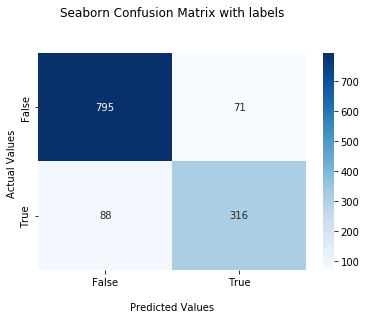

In [40]:
classifier = LogisticRegression()
df, classifier = get_weighted_ensemble_data(model_lists=models_list[:4] ,test_df=test, classifier=classifier)

In [44]:
%pwd

'/scratch/mt/ashapiro/Hate_Speech'

In [54]:
test = pd.read_csv('/home/ashapiro/Hate_speech_task/test.csv')
test

,text
0,هتهزر معايا ولا ايه 😡
1,مشفتش العرض بتاعهم لا مش مهتمة لا 😩 🐸 😂
2,عندما تكون لوحدك تحس انك لحالك صح 😊 حتى انا مث...
3,ماشاء الله الرجال باين عليه محترم البنات متى ت...
4,شسالفة احد يفهمني 😤
...,...
2536,قله حيا وين اهلهم ذولي الله لايبلانا لهالدرجه ...
2537,ثم الطحلبه 🐸
2538,يا وجه الله 😷 من اليوم ورايح شاورما انسى 🔪
2539,متخلف حتى الحلال حرمتوه 😷


In [57]:
df, models_output = ensemble(model_lists=models_list ,test_df=test, pred=True)

100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


In [61]:
preds = list(df.pred.apply(lambda x: 'OFF' if x == 1 else "NOT_OFF"))

In [63]:
preds

['NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'NOT_OFF',
 'NOT_OFF',
 'OFF',
 'OFF',
 'NOT_OF

In [64]:
with open("/home/ashapiro/Hate_speech_task/preds_test.txt", "w") as outfile:
    outfile.write("\n".join(preds))

## Top 5

In [41]:
df, models_output = ensemble(model_lists=models_list ,test_df=test)
print(classification_report(y_true=df.true.values, y_pred=df.pred.values))

100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       866
           1       0.79      0.82      0.81       404

    accuracy                           0.88      1270
   macro avg       0.86      0.86      0.86      1270
weighted avg       0.88      0.88      0.88      1270



100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       866
           1       0.81      0.78      0.79       404

    accuracy                           0.87      1270
   macro avg       0.86      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



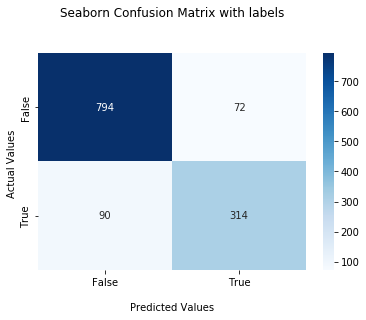

In [42]:
classifier = LogisticRegression()
df, classifier = get_weighted_ensemble_data(model_lists=models_list ,test_df=test, classifier=classifier)

# Trial

In [22]:
%cd /scratch/mt/ashapiro/Hate_Speech/

from contrastive_utils import *
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline
import pandas as pd
from tqdm.autonotebook import tqdm
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

/scratch/mt/ashapiro/Hate_Speech


In [3]:
train, test = getData(sub_task="A", pre_proccessed=True, return_type="pandas")kernel=

In [2]:
model = SentenceTransformer("./Checkpoints/SentenceBert/MarbertV2_OnlineContrastive_50K/")

In [ ]:
train.labels.values

In [4]:
X_train, y_train= model.encode(list(train.text.values)), train.labels.values

In [13]:
X_test, y_test= model.encode(list(test.text.values)), test.labels.values

In [23]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', class_weight={0:0.77751531, 1:1.4008512}))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight={0: 0.77751531, 1: 1.4008512}))])

In [24]:
y_pred = clf.predict(X_test)

In [17]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       866
           1       0.79      0.80      0.80       404

    accuracy                           0.87      1270
   macro avg       0.85      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



In [25]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       866
           1       0.79      0.81      0.80       404

    accuracy                           0.87      1270
   macro avg       0.85      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270



In [41]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier

In [47]:
clfs = [RandomForestClassifier(), AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()]

In [48]:
for clf in clfs :
    print("==================================================================")
    print(str(clf).split('.')[-1])
    clf.fit(X = X_train, y = y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_true=y_test, y_pred=y_pred))
    print("==================================================================")

RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       866
           1       0.76      0.83      0.79       404

    accuracy                           0.86      1270
   macro avg       0.84      0.85      0.85      1270
weighted avg       0.87      0.86      0.86      1270

AdaBoostClassifier()
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       866
           1       0.75      0.83      0.79       404

    accuracy                           0.86      1270
   macro avg       0.83      0.85      0.84      1270
weighted avg       0.86      0.86      0.86      1270

BaggingClassifier()
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       866
           1       0.77      0.82      0.79       404

    accuracy                           0.86      1270
   macro avg       0.84      0.85      0.85      1270
weighted

In [51]:
stacked = StackingClassifier(estimators=[('EC',ExtraTreesClassifier()),('GB',GradientBoostingClassifier()), ('BC',BaggingClassifier())])

In [52]:
stacked.fit(X = X_train, y = y_train)
y_pred = stacked.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))
print("==================================================================")

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       866
           1       0.77      0.82      0.79       404

    accuracy                           0.87      1270
   macro avg       0.84      0.85      0.85      1270
weighted avg       0.87      0.87      0.87      1270

